# Hospital queue simulation - Implementation

## **I. Team work declaration**

### *1. Team*
| Student           | Id      |
|-------------------|---------|
| Pham Tan Khoa     | 2252359 |
| Nguyen Tuan Phong | 2252612 |
| Pham Tan Phong    | 2252614 |
| Nguyen Thien Phuc | 2252645 |

### *2. Workmap declaration*

| Last name | Student ID | Design Role | Dev Role | Eval Role | Report Role | Ass1 work description (details in text)  | Rating | week 2 outcome | week 3 outcome | week 4 outcome  |
|-----------|------------|-------------|----------|-----------|-------------|------------------------------------------|-----------------|----------------|----------------|-----------------|
| Pham Tan Khoa        |2252359 | no  | no | yes  | yes  | Writing report | A |x                |x                |Evaluate team design  |
| Nguyen Tuan Phong    |2252612  | yes      | yes   | no    | no      | Overall system design, workload design | A           |x |Visualize record data    |Filling Google Collab          |
| Pham Tan Phong    |2252614   | no      | yes   | yes    | no      | Theorey queue system | A     | (Main coder) Queue simulation on Simpy   |Run simulation, record data   |Filling Google Collab |
| Nguyen Thien Phuc |2252645   | no      | no   | yes   | yes      |  Theorey queue system| A  |x  |x  |Evaluate team design   |



## **II. System design**

## System Performance Steps

### *1. Define Goal and System*
**System:** Model a simplified hospital patient flow as 4 queueing nodes: Registration -> Doctor -> (Lab with probability p_lab) -> Pharmacy.

    Goal: Measure waiting times, queue lengths, utilization, and identify bottle necks under different workloads.

### *2. Service and Outcomes*
**Services:** Registration (M/M/3), Doctor (M/M/5), Lab (M/M/4), Pharmacy (M/M/2)

    Outcomes: per-node mean waiting time Wq, service time S, response time R, time-average queue length L_q, server utilization, throughput

### *3. Select Metrics*
- **Per patient:** waiting per node, service per node, total response
- **Per node (time average):** Lq, average busy servers, utilization
- **Overall:** E[w], E[R], CI accross replications

### *4. List System Parameters*
- **External:** arrival_rate λ, p_lab
- **Node:** number of servers c_i, service rate μ_i
- **Simulation:** warmup_time, run_time, replications, seed

### *5. List Factors to Study*
- Vary λ (balanced -> stress)

### *6. Evaluation Technique*
Simulate with SimPy; run multiple replications; remove warmup; compute time-average integrals; compare with closed-form M/M/c benchmarks.

### *7. Select Workload*
**Workload A (balanced)**: λ selected to keep ρ < 0.7 in nodes

**Workload B (stress)**: increase λ until a node hits ρ ≈ 1


## System Component/Module description

    patient.py
    
**Mission:** Represents each patient traveling through the system.
- Stores timestamps of patients for each node
- Tracks which nodes a ptient visited
----
    queue_node.py
    
**Mission:** Simulates a single queueing station (registration, doctor, lab, pharmacy).
- Maintain queue length, number of patients in queue, service rate, number of servers
- Track avaerage integral number of patients in service, queue, node
----

    arrival.py
    
**Mission:** Generate new patients according to a Poisson process.
- Creates patient objects
- Sends each patient to registration (Start) node
- Make sure arrival times is Possoin distribution
----

    router.py
    
**Mission:** Controls how patients move between nodes.
- Decide patient goes to lab or directly yo pharmacy
----

    metrics.py
    
**Mission:** Compute statistics for each node and for the entire system.
- Compute per-node metrics (E[w], E[s], E[r]. E[n_q], E[n_s], E[n], utilization)
- Compute system-level metrics
- Output writing sumary record
----

    sim_engine.py
    
**Mission:** Orchestrates the entire discrete-event simulation.
- Run multiple replications
- Create directory structure
- Saves record in csv file
----

    config.py
    
**Mission:** Contains and set all global parameters.
- Allow change model parameters
----

    experiments.py
    
**Mission:** A script to run multiple workloads (λ values).
- Define list of λ values
- Experiment execution

## **III. System Implementation**



Install prerequisite library

**For simulation**
*   simpy
*   random

**For record & calculate data**
*   csv
*   math
*   statistics

**For directory record**
*   os


In [30]:
import simpy
import random
import csv
import math
from typing import Dict, List
import statistics

## Queuing Node

In [31]:
# queue_node.py: declare queue node object

class QueueNode:
    def __init__(self, env: simpy.Environment, name: str, service_rate: float, servers: int):
        self.env = env
        self.name = name
        self.service_rate = float(service_rate)  # mu per server
        self.servers = int(servers)
        self.resource = simpy.Resource(env, capacity=self.servers)
        # area integrals and bookkeeping
        self.last_event_time = 0.0
        self.queue_area = 0.0       # integral of queue_length(t) dt
        self.busy_area = 0.0        # integral of in_service(t) dt
        self.current_in_service = 0 # number of servers busy at current time
        self.system_area= 0.0
        # queue log (time, q_len) for optional post-checking
        self.queue_log: List[tuple] = []  # list of (time, queue_length)
        # count completed jobs
        self.completed_jobs = 0
        # set last_event_time to env.now initially
        self.last_event_time = env.now
    def _update_areas(self):
        now = self.env.now
        delta = now - self.last_event_time
        if delta < 0:
            delta = 0.0
        # queue length is number waiting in resource.queue
        q_len = len(self.resource.queue)
        self.queue_area += q_len * delta
        self.busy_area += self.current_in_service * delta
        self.system_area += (q_len + self.current_in_service) * delta
        self.last_event_time = now
        # optional log
        self.queue_log.append((now, q_len))
    def _sample_service_time(self) -> float:
        # Use Python's random.expovariate(lambda) where lambda = service_rate
        if self.service_rate <= 0:
            return 0.0
        return random.expovariate(self.service_rate)
    def serve(self, patient):
        # patient arrives to this node (enters queue)
        patient.record_arrival(self.name, self.env.now)
        # update areas up to now BEFORE changing counters
        self._update_areas()

        with self.resource.request() as req:
            yield req  # wait for a free server
            # just before starting service
            self._update_areas()
            # service start
            patient.record_service_start(self.name, self.env.now)
            # update counters
            self.current_in_service += 1
            # update areas after change
            self._update_areas()

            # actual service time
            service_time = self._sample_service_time()
            if service_time > 0:
                yield self.env.timeout(service_time)
            else:
                yield self.env.timeout(0)

            # service ends
            patient.record_service_end(self.name, self.env.now)
            # update counters
            self.current_in_service -= 1
            self.completed_jobs += 1
            # update area after finishing
            self._update_areas()
    def finalize(self, sim_end_time: float):
        """
        Ensure we account for tail interval until sim_end_time
        """
        now = self.env.now
        if sim_end_time > self.last_event_time:
            delta = sim_end_time - self.last_event_time
            q_len = len(self.resource.queue)
            self.queue_area += q_len * delta
            self.busy_area += self.current_in_service * delta
            self.last_event_time = sim_end_time
    def avg_queue_length(self, effective_time: float) -> float:
        if effective_time <= 0:
            return 0.0
        return self.queue_area / effective_time
    def avg_in_service(self, effective_time: float) -> float:
        if effective_time <= 0:
            return 0.0
        return self.busy_area / effective_time
    def avg_in_system(self, effective_time: float) -> float:
        if effective_time <= 0:
            return 0.0
        return self.system_area / effective_time
    def utilization(self, effective_time: float) -> float:
        denom = self.servers * effective_time
        if denom <= 0:
            return 0.0
        return self.busy_area / denom


## System configuration and execution

<img src="System.png">

In [32]:
import sys
sys.path.append("src")

from sim_engine import run_experiment
from config import config

In [33]:
# config.py: System configuration

# Change arrival_rate
# config.config['arrival_rate'] = 5.0

# Chsnge registration: mu = 1.0, c = 3
config['nodes']['registration']['service_rate'] = 8.0
config['nodes']['registration']['servers'] = 3

# Change p_lab
# config.config['routing']['p_lab'] = 0.3

In [34]:
# experiments.py: Execution 

def main():
    # change arrival rates to test workloads
    lams = [float(i) for i in range(1,10)]
    for lam in lams:
        config['arrival_rate'] = lam
        out = run_experiment(run_time=2000.0, warmup_time=200.0, replications=3, base_seed=1000, 
                             output_dir=f"outputs/results_csv/workload_lambda_{lam}", workload_name=f"lam_{lam}")
        print("Saved summary:", out['summary_file'])

if __name__ == "__main__":
    main()

Saved summary: outputs/results_csv/workload_lambda_1.0\summaries\lam_1.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_2.0\summaries\lam_2.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_3.0\summaries\lam_3.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_4.0\summaries\lam_4.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_5.0\summaries\lam_5.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_6.0\summaries\lam_6.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_7.0\summaries\lam_7.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_8.0\summaries\lam_8.0_summary.csv
Saved summary: outputs/results_csv/workload_lambda_9.0\summaries\lam_9.0_summary.csv


## **IV. Present results**

### *0. Import library to plot graph*

In [35]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

### *1. Read record from .csv files*

In [36]:
BASE_DIR = "outputs/results_csv"

pattern = os.path.join(BASE_DIR, "workload_lambda_*", "per_node_rep", "*.csv")
files = glob.glob(pattern)
print("Found per_node_rep files:", len(files))

if not files:
    raise RuntimeError(f"No CSV files found. Check working dir and path:\n  {pattern}")

all_dfs = []
for f in files:
    df = pd.read_csv(f)
    # workload looks like "lam_25.0" -> extract 25.0
    df["lambda"] = df["workload"].str.extract(r"lam_(\d+(?:\.\d+)?)").astype(float)
    all_dfs.append(df)

data = pd.concat(all_dfs, ignore_index=True)
print("Columns:", data.columns.tolist())
display(data.head())

Found per_node_rep files: 120
Columns: ['workload', 'rep', 'seed', 'node_name', 'servers', 'mu', 'lambda_effective', 'E[w]', 'E[s]', 'E[r]', 'E[n_q]', 'E[n_s]', 'E[n]', 'utilization', 'num_completed_jobs', 'lambda']


,workload,rep,seed,node_name,servers,mu,lambda_effective,E[w],E[s],E[r],E[n_q],E[n_s],E[n],utilization,num_completed_jobs,lambda
0,lam_1.0,0,1000,registration,3,8.0,NaN,0.000000,0.120872,0.120872,0.000000,0.019027,0.019018,0.006342,2146,1.0
1,lam_1.0,0,1000,doctor,5,5.0,NaN,0.000000,0.204907,0.204907,0.000000,0.051667,0.051639,0.010333,2144,1.0
2,lam_1.0,0,1000,lab,4,10.0,NaN,0.000000,0.095331,0.095331,0.000000,0.000321,0.000321,0.000080,439,1.0
3,lam_1.0,0,1000,pharmacy,2,6.0,NaN,0.000604,0.161734,0.162338,0.000601,0.032735,0.033335,0.016367,2144,1.0
4,lam_1.0,1,1001,registration,3,8.0,NaN,0.000000,0.121434,0.121434,0.000000,0.021168,0.021168,0.007056,2247,1.0


Experiment 1

### *2. Aggregated record*

In [37]:
metrics_to_avg = ["E[w]", "E[s]", "E[r]", "E[n_q]", "E[n_s]", "E[n]", "utilization"]

agg_df = (
    data
    .groupby(["lambda", "node_name"], as_index=False)[metrics_to_avg]
    .mean()
    .sort_values(["node_name", "lambda"])
)

print("Aggregated data:")
display(agg_df.head())

nodes = agg_df["node_name"].unique()

Aggregated data:


,lambda,node_name,E[w],E[s],E[r],E[n_q],E[n_s],E[n],utilization
0,1.0,doctor,0.000000e+00,0.200505,0.200505,0.000000e+00,0.053264,0.053255,0.010653
4,2.0,doctor,9.558916e-08,0.199039,0.199040,1.948107e-07,0.173267,0.173267,0.034653
8,3.0,doctor,1.669525e-05,0.199934,0.199950,5.130719e-05,0.324593,0.324644,0.064919
12,4.0,doctor,1.393327e-04,0.199468,0.199608,6.060849e-04,0.498568,0.499133,0.099714
16,5.0,doctor,1.680000e-04,0.201269,0.201433,8.886183e-04,0.700911,0.701780,0.140182


### *3. Utilization in each node*

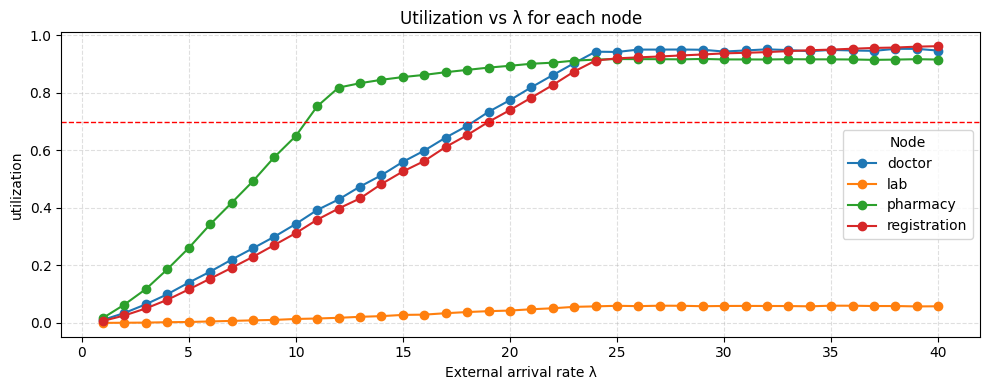

In [38]:
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 4))

for node in nodes:
    sub = agg_df[agg_df["node_name"] == node]
    ax3.plot(sub["lambda"], sub["utilization"], marker="o", label=node)

ax3.axhline(0.7, color='red', linestyle='--', linewidth=1)
ax3.set_title("Utilization vs λ for each node")
ax3.set_xlabel("External arrival rate λ")
ax3.set_ylabel("utilization")
ax3.grid(True, linestyle="--", alpha=0.4)
ax3.legend(title="Node")
plt.tight_layout()
plt.show()

From the utilization graph, we can see

- Bottleneck is the Pharmacy node (end node), with λ = 11.0
- Continue increase λ, Doctor node and Registration node will be unstable at λ = 24.0

### *4. Experiment 1: Balanced workload*

4.1 Figure 1: E[w], E[s], E[r] in balanced workload

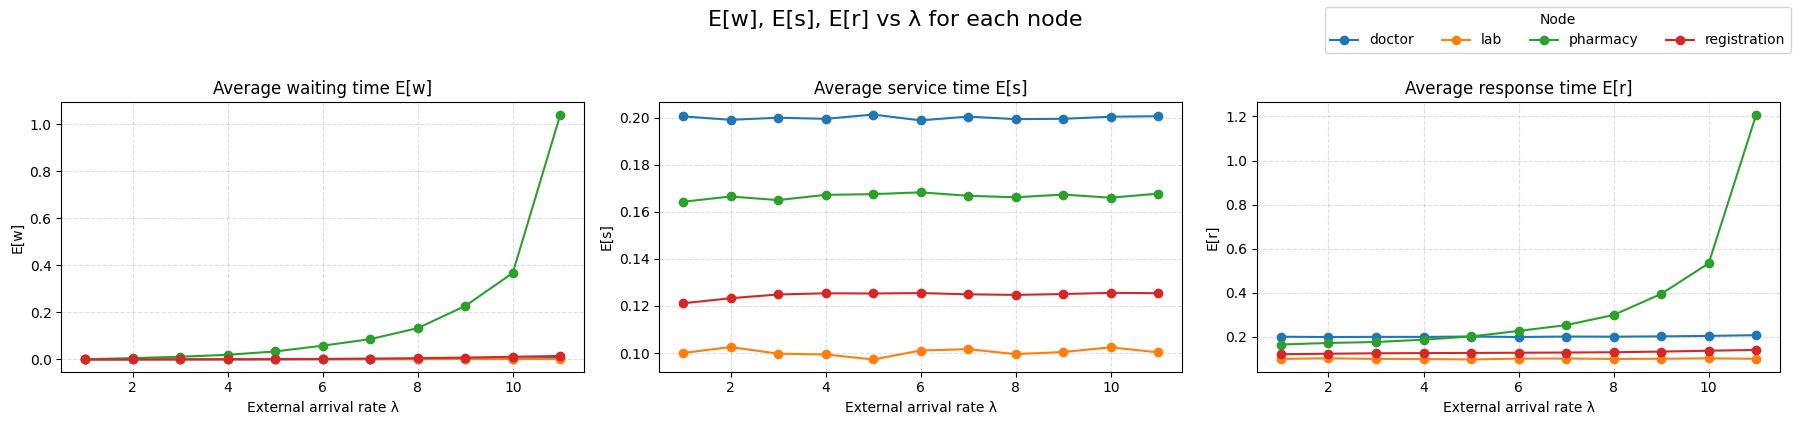

In [39]:
filtered = agg_df[agg_df["lambda"] <= 11.0]
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_1 = ["E[w]", "E[s]", "E[r]"]
titles_1 = ["Average waiting time E[w]",
            "Average service time E[s]",
            "Average response time E[r]"]

for ax, metric, title in zip(axes1, metrics_1, titles_1):
    for node in nodes:
        #sub = agg_df[agg_df["node_name"] == node]
        sub = filtered[filtered["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes1[0].get_legend_handles_labels()
fig1.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig1.suptitle("E[w], E[s], E[r] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

4.2 Figure 2: E[n_q], E[n_s], E[n] in balanced workload

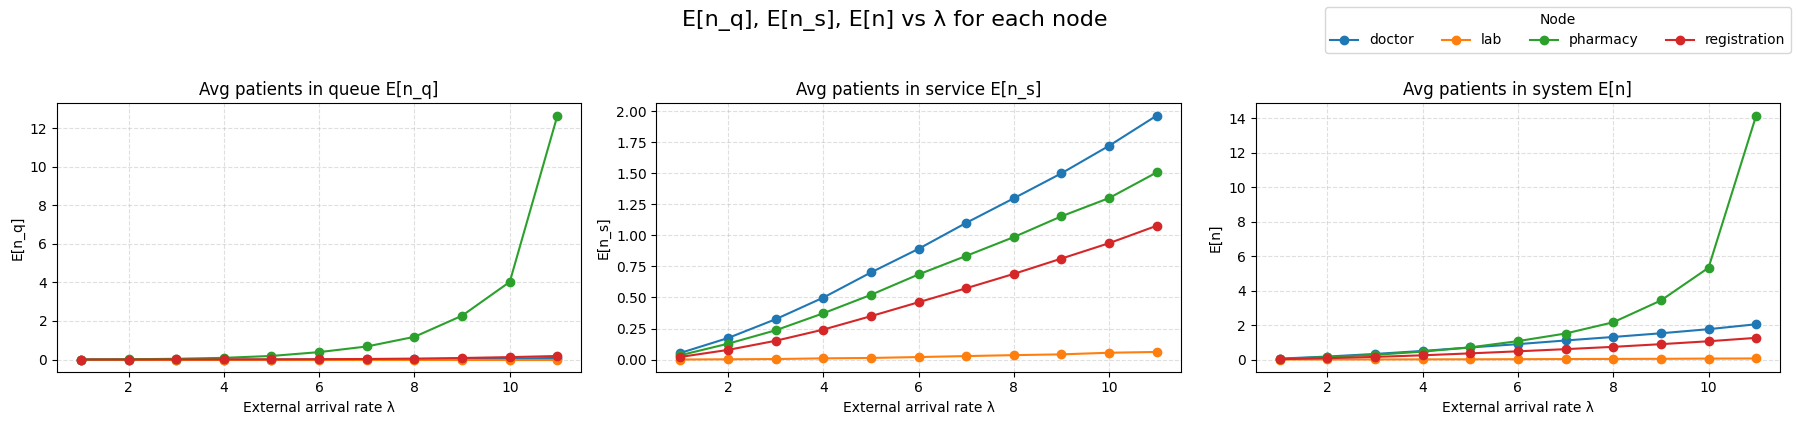

In [40]:
filtered = agg_df[agg_df["lambda"] <= 11.0]
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_2 = ["E[n_q]", "E[n_s]", "E[n]"]
titles_2 = ["Avg patients in queue E[n_q]",
            "Avg patients in service E[n_s]",
            "Avg patients in system E[n]"]

for ax, metric, title in zip(axes2, metrics_2, titles_2):
    for node in nodes:
        #sub = agg_df[agg_df["node_name"] == node]
        sub = filtered[filtered["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes2[0].get_legend_handles_labels()
fig2.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig2.suptitle("E[n_q], E[n_s], E[n] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### *5. Experiment 2: Stress workload*

5.1 Figure 1: E[w], E[s], E[r] in stress workload

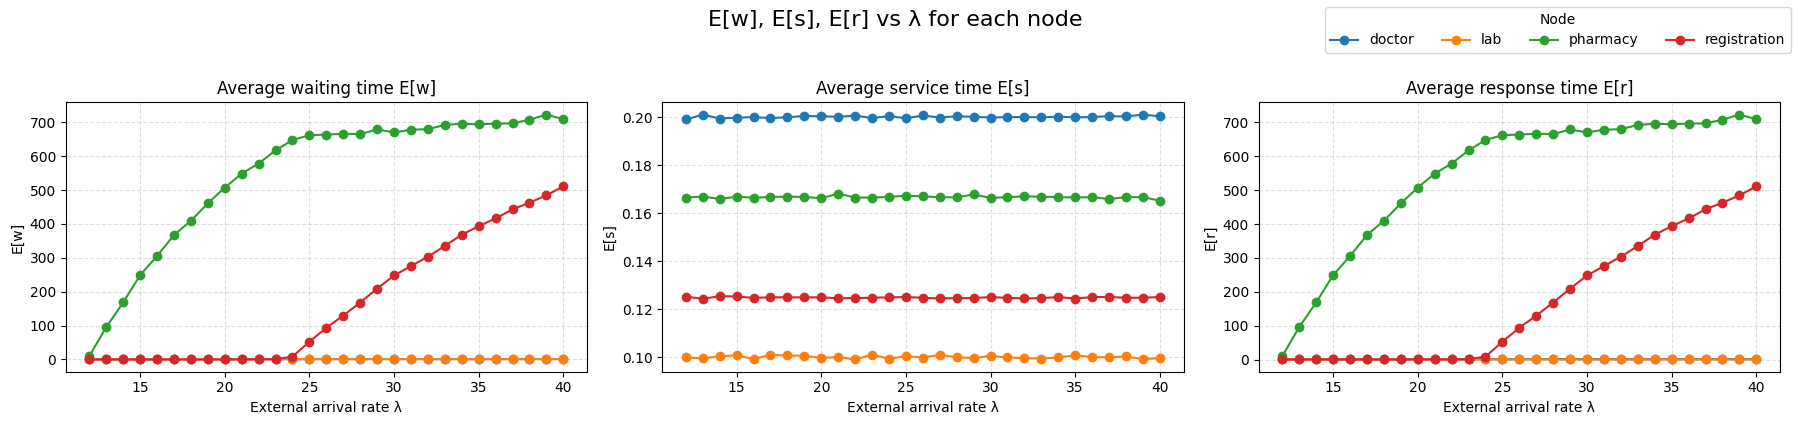

In [41]:
filtered = agg_df[agg_df["lambda"] >= 12.0]
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_1 = ["E[w]", "E[s]", "E[r]"]
titles_1 = ["Average waiting time E[w]",
            "Average service time E[s]",
            "Average response time E[r]"]

for ax, metric, title in zip(axes1, metrics_1, titles_1):
    for node in nodes:
        #sub = agg_df[agg_df["node_name"] == node]
        sub = filtered[filtered["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes1[0].get_legend_handles_labels()
fig1.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig1.suptitle("E[w], E[s], E[r] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

5.2 Figure 2: E[n_q], E[n_s], E[n] in stress workload

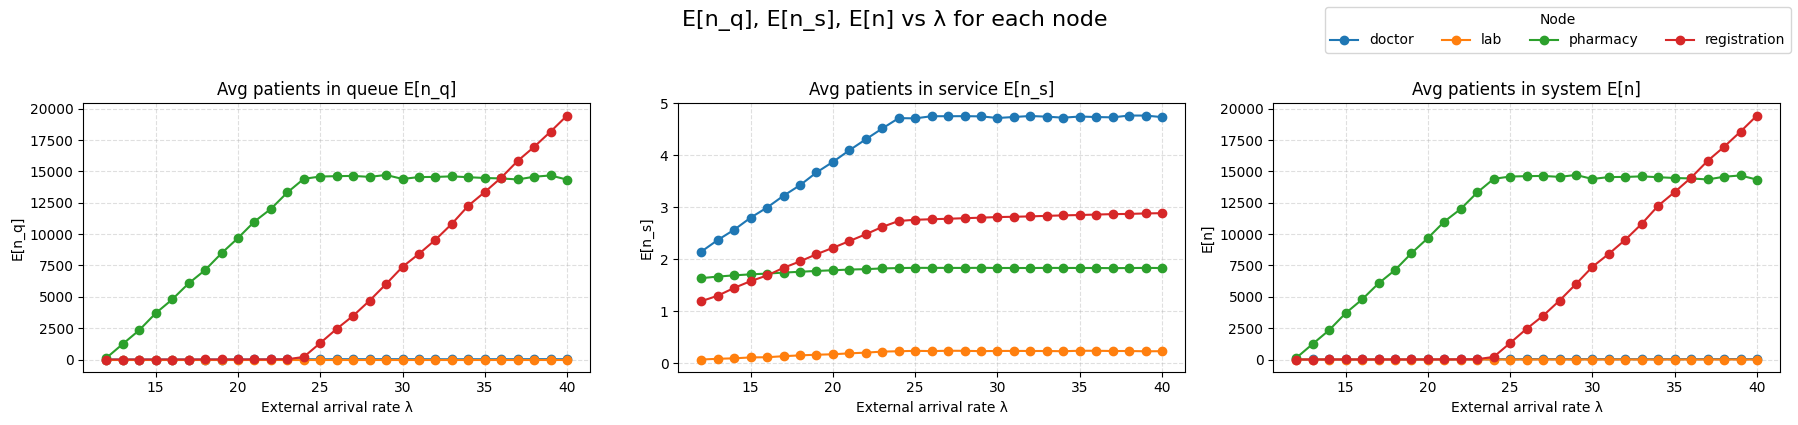

In [42]:
filtered = agg_df[agg_df["lambda"] >= 12.0]
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_2 = ["E[n_q]", "E[n_s]", "E[n]"]
titles_2 = ["Avg patients in queue E[n_q]",
            "Avg patients in service E[n_s]",
            "Avg patients in system E[n]"]

for ax, metric, title in zip(axes2, metrics_2, titles_2):
    for node in nodes:
        #sub = agg_df[agg_df["node_name"] == node]
        sub = filtered[filtered["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes2[0].get_legend_handles_labels()
fig2.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig2.suptitle("E[n_q], E[n_s], E[n] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## **V. Conclusion**

From the simulation, we notice that

- Pharmacy node is the bottleneck of overall system, which is λ = 10.0 is the threshold for stable system
- We should increase number of servers in Pharmacy node, from 2 servers to 4 servers, as the next threshold is λ = 19.0 at registration and doctor node
- We should reduce number of servers, or service rate in Lab node